### **Baseline Version**

In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# --- Load compatibility data (updated Windows paths) ---
bt_df = pd.read_excel(r"Blood Type Compatibility (Bij).xlsx", index_col=0)
tt_df = pd.read_excel(r"Tissue Type Compatibility (Tij).xlsx", index_col=0)

# --- Helper to convert common marks to 0/1 ---
def to_binary(df):
    def cell_to_bin(v):
        if pd.isna(v):
            return 0
        if isinstance(v, (int, float, np.integer, np.floating)):
            return 1 if float(v) != 0 else 0
        s = str(v).strip().lower()
        if s in ("1","true","t","yes","y","✓","x"):
            return 1
        return 0
    return df.applymap(cell_to_bin).astype(int)

bt = to_binary(bt_df)
tt = to_binary(tt_df)

if bt.shape != tt.shape:
    raise ValueError(f"Blood and tissue matrices shapes differ: {bt.shape} vs {tt.shape}")

n_pairs = bt.shape[0]
donors = list(range(n_pairs))
patients = list(range(n_pairs))

# combined compatibility: 1 only if BOTH blood and tissue compatible
compat = (bt.values * tt.values).astype(int)

# --- Build Gurobi model ---
m = gp.Model("KPD_Optimization")
x = {}
for i in donors:
    for j in patients:
        x[(i,j)] = m.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")

m.update()
m.setObjective(gp.quicksum(x[(i,j)] for i in donors for j in patients), GRB.MAXIMIZE)

# donor capacity and patient assignment
for i in donors:
    m.addConstr(gp.quicksum(x[(i,j)] for j in patients) <= 1, name=f"DonorCap_{i}")
for j in patients:
    m.addConstr(gp.quicksum(x[(i,j)] for i in donors) <= 1, name=f"PatientAssign_{j}")

# compatibility: allow only when BOTH match
for i in donors:
    for j in patients:
        if compat[i,j] == 0:
            m.addConstr(x[(i,j)] == 0, name=f"Incompat_{i}_{j}")

# pair consistency: donor k donates iff patient k receives
for k in range(n_pairs):
    m.addConstr(gp.quicksum(x[(k,j)] for j in patients) == gp.quicksum(x[(i,k)] for i in donors),
                name=f"PairConsistency_{k}")

# solve
m.optimize()

# --- Output final assignment summary ---
print("\n" + "="*60)
print("FINAL SOLUTION SUMMARY")
print("="*60)
status = m.status
print(f"Solver status: {status} ({'OPTIMAL' if status==GRB.OPTIMAL else 'NOT OPTIMAL'})")

if status == GRB.OPTIMAL or status == GRB.TIME_LIMIT:
    donor_to_patient = {i: None for i in donors}
    patient_to_donor = {j: None for j in patients}
    for i in donors:
        for j in patients:
            val = x[(i,j)].X
            if val is not None and val > 0.5:
                donor_to_patient[i] = j
                patient_to_donor[j] = i

    total_transplants = sum(1 for v in donor_to_patient.values() if v is not None)
    print(f"Total transplants: {total_transplants}\n")

    print("Donor assignments (donor -> patient):")
    for i in donors:
        if donor_to_patient[i] is not None:
            print(f"  Donor {i} -> Patient {donor_to_patient[i]}")
        else:
            print(f"  Donor {i} -> not assigned")

    print("\nPatient assignments (patient <- donor):")
    for j in patients:
        if patient_to_donor[j] is not None:
            print(f"  Patient {j} <- Donor {patient_to_donor[j]}")
        else:
            print(f"  Patient {j} <- not assigned")
else:
    print("No optimal solution found; inspect solver output.")
print("\n" + "="*60)
# ...existing code...

Set parameter Username
Set parameter LicenseID to value 2702390
Academic license - for non-commercial use only - expires 2026-09-03
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 639 rows, 625 columns and 3014 nonzeros
Model fingerprint: 0xac99a757
Variable types: 0 continuous, 625 integer (625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 624 rows and 609 columns
Presolve time: 0.00s
Presolved: 15 rows, 16 columns, 60 nonzeros
Found heuristic solution: objective 4.0000000
Variable types: 0 continuous, 16 integer (16 binary)
Found heuristic solution: objective 9.0000000

Root relaxation: objecti

C:\Users\parne\AppData\Local\Temp\ipykernel_34408\3288003580.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(cell_to_bin).astype(int)
C:\Users\parne\AppData\Local\Temp\ipykernel_34408\3288003580.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(cell_to_bin).astype(int)


In [2]:
import pandas as pd
import numpy as np
from gurobipy import *

# ============================================================================
# STEP 1: READ EXCEL FILES
# ============================================================================
B_file = r"Blood Type Compatibility (Bij).xlsx"
T_file = r"Tissue Type Compatibility (Tij).xlsx"

# Read compatibility matrices
B = pd.read_excel(B_file, index_col=0).values
T = pd.read_excel(T_file, index_col=0).values

num_donors = B.shape[0]
num_patients = B.shape[1]

print(f"Donors: {num_donors}, Patients: {num_patients}")
print("Matrices loaded successfully!\n")

# ============================================================================
# STEP 2: CREATE GUROBI MODEL
# ============================================================================
model = Model("KPD_Optimization")

# ============================================================================
# STEP 3: DECISION VARIABLES
# ============================================================================
x = {}
for i in range(num_donors):
    for j in range(num_patients):
        x[i, j] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")

model.update()

# ============================================================================
# STEP 4: OBJECTIVE FUNCTION
# ============================================================================
model.setObjective(quicksum(x[i, j] for i in range(num_donors) for j in range(num_patients)), GRB.MAXIMIZE)

# ============================================================================
# STEP 5: CONSTRAINTS
# ============================================================================
# Donor capacity
for i in range(num_donors):
    model.addConstr(quicksum(x[i, j] for j in range(num_patients)) <= 1, name=f"donor_{i}")

# Patient assignment
for j in range(num_patients):
    model.addConstr(quicksum(x[i, j] for i in range(num_donors)) <= 1, name=f"patient_{j}")

# Compatibility (both blood AND tissue)
for i in range(num_donors):
    for j in range(num_patients):
        if B[i, j] * T[i, j] == 0:
            model.addConstr(x[i, j] == 0, name=f"compat_{i}_{j}")

# Pair consistency
for k in range(min(num_donors, num_patients)):
    model.addConstr(quicksum(x[k, j] for j in range(num_patients)) == 
                    quicksum(x[i, k] for i in range(num_donors)), 
                    name=f"pair_{k}")

# ============================================================================
# STEP 6: SOLVE
# ============================================================================
model.optimize()

# ============================================================================
# STEP 7: RESULTS
# ============================================================================
print("=" * 70)
print("OPTIMIZATION RESULTS")
print("=" * 70)

if model.status == GRB.OPTIMAL:
    print(f"\n✓ Optimal solution found!")
    print(f"✓ Maximum transplants: {int(model.objVal)}\n")
    
    transplants = []
    for i in range(num_donors):
        for j in range(num_patients):
            if x[i, j].X > 0.5:
                transplants.append({'Donor': i + 1, 'Patient': j + 1})
    
    print("TRANSPLANT ASSIGNMENTS:")
    print("-" * 70)
    for t in transplants:
        print(f"Donor {t['Donor']:2d} → Patient {t['Patient']:2d}")
    
    print("\n" + "-" * 70)
    print("SUMMARY:")
    print("-" * 70)
    donors_assigned = len(set([t['Donor'] for t in transplants]))
    patients_assigned = len(set([t['Patient'] for t in transplants]))
    print(f"Donors assigned:   {donors_assigned}")
    print(f"Patients assigned: {patients_assigned}")
    print(f"Total transplants: {len(transplants)}")
else:
    print(f"Status: {model.status}")

print("=" * 70)

Donors: 25, Patients: 25
Matrices loaded successfully!

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 639 rows, 625 columns and 3014 nonzeros
Model fingerprint: 0xac99a757
Variable types: 0 continuous, 625 integer (625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 624 rows and 609 columns
Presolve time: 0.00s
Presolved: 15 rows, 16 columns, 60 nonzeros
Found heuristic solution: objective 4.0000000
Variable types: 0 continuous, 16 integer (16 binary)
Found heuristic solution: objective 9.0000000

Root relaxation: objective 1.200000e+01, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    

### **Forced Pairing**

In [3]:
import pandas as pd
import numpy as np
from gurobipy import *

# ============================================================================
# STEP 1: READ EXCEL FILES
# ============================================================================
B_file = r"Blood Type Compatibility (Bij).xlsx"
T_file = r"Tissue Type Compatibility (Tij).xlsx"

# Read compatibility matrices
B = pd.read_excel(B_file, index_col=0).values
T = pd.read_excel(T_file, index_col=0).values

num_donors = B.shape[0]
num_patients = B.shape[1]

print(f"Donors: {num_donors}, Patients: {num_patients}")
print("Matrices loaded successfully!\n")

# ============================================================================
# STEP 2: CREATE GUROBI MODEL
# ============================================================================
model = Model("KPD_Optimization_Donor23_Patient23_Forced")

# ============================================================================
# STEP 3: DECISION VARIABLES
# ============================================================================
x = {}
for i in range(num_donors):
    for j in range(num_patients):
        x[i, j] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")

model.update()

# ============================================================================
# STEP 4: OBJECTIVE FUNCTION
# ============================================================================
model.setObjective(quicksum(x[i, j] for i in range(num_donors) for j in range(num_patients)), GRB.MAXIMIZE)

# ============================================================================
# STEP 5: CONSTRAINTS
# ============================================================================
# Donor capacity
for i in range(num_donors):
    model.addConstr(quicksum(x[i, j] for j in range(num_patients)) <= 1, name=f"donor_{i}")

# Patient assignment
for j in range(num_patients):
    model.addConstr(quicksum(x[i, j] for i in range(num_donors)) <= 1, name=f"patient_{j}")

# Compatibility (both blood AND tissue)
for i in range(num_donors):
    for j in range(num_patients):
        if B[i, j] * T[i, j] == 0:
            model.addConstr(x[i, j] == 0, name=f"compat_{i}_{j}")

# Pair consistency
for k in range(min(num_donors, num_patients)):
    model.addConstr(quicksum(x[k, j] for j in range(num_patients)) == 
                    quicksum(x[i, k] for i in range(num_donors)), 
                    name=f"pair_{k}")

# NEW CONSTRAINT: Force Donor 23 (index 22) to donate to Patient 23 (index 22)
model.addConstr(x[22, 22] == 1, name="force_donor23_patient23")

print("Model created with all constraints!")
print(f"Number of variables: {model.numVars}")
print(f"Number of constraints: {model.numConstrs}")

# ============================================================================
# STEP 6: SOLVE
# ============================================================================
print("\nSolving the optimization model...")
print("=" * 70)

model.optimize()

# ============================================================================
# STEP 7: RESULTS
# ============================================================================
print("=" * 70)
print("OPTIMIZATION RESULTS (Donor 23 - Patient 23 FORCED)")
print("=" * 70)

if model.status == GRB.OPTIMAL:
    print(f"\n✓ Optimal solution found!")
    print(f"✓ Maximum transplants: {int(model.objVal)}\n")
    
    transplants = []
    for i in range(num_donors):
        for j in range(num_patients):
            if x[i, j].X > 0.5:
                transplants.append({'Donor': i + 1, 'Patient': j + 1})
    
    print("TRANSPLANT ASSIGNMENTS:")
    print("-" * 70)
    for t in transplants:
        marker = " ← FORCED" if t['Donor'] == 23 and t['Patient'] == 23 else ""
        print(f"Donor {t['Donor']:2d} → Patient {t['Patient']:2d}{marker}")
    
    print("\n" + "-" * 70)
    print("SUMMARY:")
    print("-" * 70)
    donors_assigned = len(set([t['Donor'] for t in transplants]))
    patients_assigned = len(set([t['Patient'] for t in transplants]))
    print(f"Donors assigned:   {donors_assigned}")
    print(f"Patients assigned: {patients_assigned}")
    print(f"Total transplants: {len(transplants)}")
    print(f"\n✓ Donor 23 matched with Patient 23: YES")
else:
    print(f"Status: {model.status}")
    if model.status == GRB.INFEASIBLE:
        print("✗ Model is infeasible - Donor 23 and Patient 23 are not compatible!")

print("=" * 70)

Donors: 25, Patients: 25
Matrices loaded successfully!

Model created with all constraints!
Number of variables: 625
Number of constraints: 0

Solving the optimization model...
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 640 rows, 625 columns and 3015 nonzeros
Model fingerprint: 0x58c87c37
Variable types: 0 continuous, 625 integer (625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 625 rows and 609 columns
Presolve time: 0.00s
Presolved: 15 rows, 16 columns, 60 nonzeros
Variable types: 0 continuous, 16 integer (16 binary)
Found heuristic solution: objective 6.0000000

Root relaxation: objectiv

### **Model Extension with Blood Type Conversion to O**

In [4]:
# Kidney exchange using only tissue-type compatibility (Tij)
# Reads Tij from 'Tissue Type Compatibility (Tij).xlsx' 

import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum
import os

# Attempt to load Tij matrix from Excel
tij_file = 'Tissue Type Compatibility (Tij).xlsx'
T = None
if os.path.exists(tij_file):
    try:
        T_df = pd.read_excel(tij_file, index_col=0)
        # Ensure it's numeric 0/1
        T = (T_df.values.astype(int) != 0).astype(int)
        donors = list(T_df.index)
        patients = list(T_df.columns)
        print(f"Loaded Tij from '{tij_file}' with shape {T.shape}")
    except Exception as e:
        print(f"Error reading {tij_file}: {e}")
        T = None
else:
    T = None

# Require Tij matrix be provided by the user; do not construct a fallback here
if T is None:
    raise RuntimeError(f"Tij matrix not found. Please provide '{tij_file}' in the working directory.")

n_donors, n_patients = T.shape
if n_donors != n_patients:
    print("Warning: Tij is not square. Proceeding with rectangular donor/patient sets.")

# Index sets
I = range(n_donors)
J = range(n_patients)

# Build Gurobi model
model = Model('KPD_Tij_only')
# Solver log enabled in notebook (set to 0 for silent)
model.setParam('OutputFlag', 1)

# Decision variables x_ij
x = model.addVars(I, J, vtype=GRB.BINARY, name='x')

# Objective: maximize total number of transplants
model.setObjective(quicksum(x[i,j] for i in I for j in J), GRB.MAXIMIZE)

# Constraints:
# 1) Each donor can donate to at most one patient
for i in I:
    model.addConstr(quicksum(x[i,j] for j in J) <= 1, name=f'donor_cap_{i}')

# 2) Each patient can receive at most one kidney
for j in J:
    model.addConstr(quicksum(x[i,j] for i in I) <= 1, name=f'patient_cap_{j}')

# 3) Compatibility: x_ij == 0 when Tij==0
for i in I:
    for j in J:
        if T[i,j] == 0:
            model.addConstr(x[i,j] == 0, name=f'compat_{i}_{j}')
# If Tij is 1, no constraint needed (x binary already)

# 4) Pair consistency: for pair k, donor k gives iff patient k receives
# Require sum_j x_kj == sum_i x_ik for each k (assuming pairs are aligned)
if n_donors == n_patients:
    for k in range(n_donors):
        model.addConstr(quicksum(x[k,j] for j in J) == quicksum(x[i,k] for i in I), name=f'pair_consistency_{k}')
else:
    print('Skipping pair-consistency constraints because Tij is not square (donor/patient counts differ).')

# Solve
model.optimize()

# Extract solution
opt_val = int(model.objVal) if model.status == GRB.OPTIMAL else None
print('\nOptimal number of transplants:', opt_val)

transplants = []
for i in I:
    for j in J:
        if x[i,j].X > 0.5:
            transplants.append((i+1, j+1))

print('\nTransplants (donor_pair -> patient_pair):')
for a,b in transplants:
    print(f'  {a} -> {b}')

# Save solution to CSV (disabled - saving to local disk removed)
out_df = pd.DataFrame(transplants, columns=['DonorPair','PatientPair'])
print("Solution generation completed.")

Loaded Tij from 'Tissue Type Compatibility (Tij).xlsx' with shape (25, 25)
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 561 rows, 625 columns and 2936 nonzeros
Model fingerprint: 0xdf4789be
Variable types: 0 continuous, 625 integer (625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 490 rows and 487 columns
Presolve time: 0.00s
Presolved: 71 rows, 138 columns, 534 nonzeros
Found heuristic solution: objective 5.0000000
Variable types: 0 continuous, 138 integer (138 binary)

Root relaxation: objective 2.000000e+01, 62 iterations, 0.00 seconds (0.00 work units)


Using existing `T` matrix from notebook kernel.
Loaded Bij from 'Blood Type Compatibility (Bij).xlsx' with shape (25, 25)
No explicit O1 template row found in Bij; assuming O1 donors are compatible with all patients (O1_j = 1 for all j).


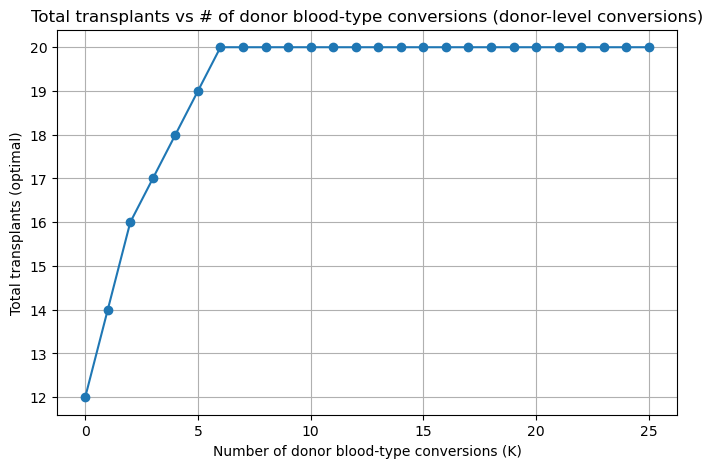

In [5]:
# Simulation + Plot: total transplants vs # of donor blood-type conversions (using Bij)
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import pandas as pd

# Ensure Tij (T) is loaded in this kernel; if not, load it here so the cell can run standalone
tij_file = 'Tissue Type Compatibility (Tij).xlsx'
if 'T' not in globals():
    if os.path.exists(tij_file):
        try:
            T_df = pd.read_excel(tij_file, index_col=0)
            T = (T_df.values.astype(int) != 0).astype(int)
            donors = list(T_df.index)
            patients = list(T_df.columns)
            print(f"Loaded Tij from '{tij_file}' with shape {T.shape}")
        except Exception as e:
            raise RuntimeError(f"Error reading {tij_file}: {e}")
    else:
        raise RuntimeError(f"Tij matrix not found and variable `T` is not defined. Please run the Tij-loading cell or place '{tij_file}' in the working directory.")
else:
    print('Using existing `T` matrix from notebook kernel.')

# Algebraic formulation (expressed here as comments):
# - Decision vars:
#     x_ij in {0,1} for donor i assigned to patient j
#     c_i  in {0,1} for whether donor i is converted to blood type O1
# - Objective: maximize sum_{i,j} x_ij
# - Constraints:
#     1) Each donor donates at most once: sum_j x_ij <= 1   for all i
#     2) Each patient receives at most once: sum_i x_ij <= 1  for all j
#     3) Compatibility after conversions: x_ij <= C_ij + c_i * O1_j
#        where C_ij = Tij * Bij (combined tissue & blood-type compatibility)
#        Note: because (3) enforces Tij, conversions cannot override tissue incompatibility.
#     5) Conversion budget: sum_i c_i <= K  (K is number of allowed conversions)
#     6) Pair consistency (if pairs aligned and n_d == n_p): sum_j x_kj == sum_i x_ik  for all k
# - All x_ij and c_i binary.

# Load Bij (blood-type compatibility) if not already available
bij_file = 'Blood Type Compatibility (Bij).xlsx'
if 'Bij' not in globals():
    Bij = None
    Bij_df = None
    if os.path.exists(bij_file):
        try:
            Bij_df = pd.read_excel(bij_file, index_col=0)
            Bij = (Bij_df.values.astype(int) != 0).astype(int)
            print(f"Loaded Bij from '{bij_file}' with shape {Bij.shape}")
        except Exception as e:
            print(f"Error reading {bij_file}: {e}")
            Bij = None
    else:
        print(f"Bij file '{bij_file}' not found. Falling back to Bij = all ones (no blood-type restrictions).")
else:
    print('Using existing `Bij` from kernel variables.')

# Construct combined compatibility C = Tij * Bij
if Bij is None:
    C = T.copy()
else:
    if T.shape != Bij.shape:
        raise RuntimeError(f"Shape mismatch: Tij {T.shape} vs Bij {Bij.shape}. Ensure both matrices align (rows = donors, cols = patients). If Bij is arranged differently, load Bij_df and adjust accordingly.")
    C = (T * Bij)

# Determine O1 compatibility row from Bij (if available)
# Try to find an index row that represents donors with blood type O1.
O1_row = None
if 'Bij_df' in globals() and Bij_df is not None:
    for idx in Bij_df.index:
        s = str(idx).lower()
        if 'o1' in s or s.strip().upper() == 'O' or s.strip().upper().startswith('O1'):
            O1_row = (Bij_df.loc[idx].values.astype(int) != 0).astype(int)
            print(f"Using row '{idx}' from Bij as O1 template.")
            break
# If no explicit O1 template found, fall back to universal compatibility for O1
if O1_row is None:
    print("No explicit O1 template row found in Bij; assuming O1 donors are compatible with all patients (O1_j = 1 for all j).")
    O1_row = np.ones(C.shape[1], dtype=int)

# A helper solver that builds and solves the matching model given a compatibility matrix C
# (kept for reference; it models only compatibility C without conversion variables)
def solve_with_C(C_matrix, pair_consistency=True, outputflag=0):
    from gurobipy import Model, GRB, quicksum
    Cm = np.array(C_matrix, dtype=int)
    n_d, n_p = Cm.shape
    I = range(n_d)
    J = range(n_p)
    m = Model('KPD_C_only')
    m.setParam('OutputFlag', outputflag)
    x = m.addVars(I, J, vtype=GRB.BINARY)
    m.setObjective(quicksum(x[i,j] for i in I for j in J), GRB.MAXIMIZE)
    for i in I:
        m.addConstr(quicksum(x[i,j] for j in J) <= 1)
    for j in J:
        m.addConstr(quicksum(x[i,j] for i in I) <= 1)
    for i in I:
        for j in J:
            if Cm[i,j] == 0:
                m.addConstr(x[i,j] == 0)
    if pair_consistency and n_d == n_p:
        for k in range(n_d):
            m.addConstr(quicksum(x[k,j] for j in J) == quicksum(x[i,k] for i in I))
    m.optimize()
    if m.status == GRB.OPTIMAL:
        return int(m.objVal)
    else:
        return None

# New: solve model with donor-level conversions (c_i) using combined compatibility C and O1_row
# Now requires Tij (T_matrix) so we can enforce tissue compatibility separately (conversions do not override Tij)
def solve_with_conversions_donor_level_using_C(C_matrix, T_matrix, O1_row, K, pair_consistency=True, outputflag=0):
    from gurobipy import Model, GRB, quicksum
    Cm = np.array(C_matrix, dtype=int)
    Tm = np.array(T_matrix, dtype=int)
    O1r = np.array(O1_row, dtype=int)
    n_d, n_p = Cm.shape
    I = range(n_d)
    J = range(n_p)
    m = Model('KPD_with_conversions_C')
    m.setParam('OutputFlag', outputflag)

    # Variables
    x = m.addVars(I, J, vtype=GRB.BINARY, name='x')
    c = m.addVars(I, vtype=GRB.BINARY, name='c')

    # Objective
    m.setObjective(quicksum(x[i,j] for i in I for j in J), GRB.MAXIMIZE)

    # Donor / patient capacity
    for i in I:
        m.addConstr(quicksum(x[i,j] for j in J) <= 1)
    for j in J:
        m.addConstr(quicksum(x[i,j] for i in I) <= 1)

    # Enforce tissue compatibility: conversions cannot override Tij
    for i in I:
        for j in J:
            m.addConstr(x[i,j] <= Tm[i,j])

    # Compatibility after conversion: x_ij <= C_ij + c_i * O1_j
    for i in I:
        for j in J:
            # Right-hand side is 0/1 + 0/1 => integer; guard to keep it <=1
            m.addConstr(x[i,j] <= Cm[i,j] + c[i] * int(O1r[j]))

    # Conversion budget
    m.addConstr(quicksum(c[i] for i in I) <= K)

    # Pair consistency if applicable
    if pair_consistency and n_d == n_p:
        for k in I:
            m.addConstr(quicksum(x[k,j] for j in J) == quicksum(x[i,k] for i in I))

    # Solve
    m.optimize()
    if m.status == GRB.OPTIMAL:
        return int(m.objVal)
    else:
        return None

# Run simulation: sweep K from 0 to n_d (convert up to all donors)
# Note: this may be slow if n_d is large; you can cap max_K if needed.
n_d, n_p = C.shape
max_K = n_d
ys = []
for K in range(0, max_K+1):
    val = solve_with_conversions_donor_level_using_C(C, T, O1_row, K, pair_consistency=(C.shape[0]==C.shape[1]), outputflag=0)
    ys.append(val)

xs = list(range(0, len(ys)))

plt.figure(figsize=(8,5))
plt.plot(xs, ys, marker='o')
plt.xlabel('Number of donor blood-type conversions (K)')
plt.ylabel('Total transplants (optimal)')
plt.title('Total transplants vs # of donor blood-type conversions (donor-level conversions)')
plt.grid(True)
plt.show()
# print('Plot saved to transplants_vs_conversions_donor_level.png')
